# Análise, Modelagem e Avaliação: Churn Prediction

Este notebook documenta o processo de construção de um modelo de Classificação Binária para prever o **cancelamento de clientes (Churn)** em uma empresa de telecomunicações. O objetivo principal é não apenas obter um modelo preditivo, mas também identificar os **principais fatores** que levam ao cancelamento, fornecendo *insights* acionáveis para a retenção de clientes.

## Carregamento, Inspeção e Limpeza Inicial do Dataset

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = "../data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Formato: {df.shape}")
    print(df.info())
    display(df.head(5))
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em {DATA_PATH}. Verifique o caminho.")

Formato: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Limpeza e Tratamento da Coluna 'TotalCharges'

A inspeção inicial revelou que a coluna `TotalCharges`, que representa um valor monetário e deveria ser numérica, está incorretamente classificada como `object` (string). Isso geralmente indica a presença de caracteres não numéricos. Faremos a conversão dessa coluna para `float` e, ao mesmo tempo, identificaremos quantos valores inválidos existem para posterior tratamento.

In [2]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
print(f"Tipo da coluna 'TotalCharges': {df['TotalCharges'].dtype}")
print(f"Valores nulos na coluna 'TotalCharges': {df['TotalCharges'].isnull().sum()}")

Tipo da coluna 'TotalCharges': float64
Valores nulos na coluna 'TotalCharges': 11


In [3]:
print(f"Índice dos valores nulos na coluna 'TotalCharges': {np.where(df['TotalCharges'].isnull())[0].tolist()}")

Índice dos valores nulos na coluna 'TotalCharges': [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


Com isso, a coluna `TotalCharges` agora está corretamente tipada como `float64` e, além disso, identificou-se um total de **11 valores nulos (`NaN`)** restantes. 

---

### Tratamento de Valores Nulos e Remoção da Coluna Identificadora

Agora que isolamos os valores nulos, é necessário que os tratemos antes de partir para o treinamento do modelo. Apesar de serem poucos nulos, optaremos por fazer a **imputação pela mediana**, preservando assim todos os dados.
Podemos também fazer a remoção da coluna `customerID`, tendo em vista que ela não agrega valor preditivo.

In [4]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df = df.drop('customerID', axis = 1)

print(f"Total de valores nulos no DF: {df.isnull().sum()}")
print(f"Novo formato do DF: {df.shape}")

Total de valores nulos no DF: gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Novo formato do DF: (7043, 20)


## Análise Exploratória de Dados
### Análise da Variável *Target*
O objetivo agora é entender a variável *target* (`Churn`) e como as *features* se relacionam com ela.

In [5]:
print(f"Distribuição da variável alvo: {df['Churn'].value_counts(normalize=True)}")

Distribuição da variável alvo: Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


Temos um desbalanceamento:

* Clientes que **não cancelaram** (`No`): 73.46%
* Clientes que **cancelaram** (`yes`): 26.54%

Quase três quartos dos clientes não cancelam. Se criarmos um modelo que apenas prevê "Não" para todos, teremos uma Acurácia de $≈73.46$%. Isso significa que a Acurácia (**Accuracy**) será uma métrica enganosa. Nosso foco terá que ser em **Recall**, **Precisão** e **AUC**.

---

### Pré-processamento e Feature Engineering
Antes de prosseguirmos para a visualização, é necessário finalizar o tratamento dos dados, focando em transformar as *strings* em números para a modelagem.
* Converteremos a variável alvo `Churn` de *object* (`yes`, `no`) para binário (`int`: $0$ ou $1$)
* Identificaremos e trataremos as colunas binárias que ainda estão como *object*, também convertendo-as para $0$ ou $1$.
* Por fim, identificaremos e trataremos as colunas categóricas que possuem mais de duas classes, utilizando o `pd.get_dummies()`.

In [6]:
# Codificação da variável alvo
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"\nDistribuição da variável alvo após codificação:\n {df['Churn'].value_counts(normalize=True)}", )

# Codificação das colunas binárias
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

def encode_binary_columns(df: pd.DataFrame):
    """
    Detecta colunas binárias que contenham apenas 'yes'/'no' (qualquer capitalização)
    e as converte para 1/0.
    
    Retorna:
      - df_encoded: DataFrame com as colunas convertidas
      - binary_cols: lista das colunas convertidas
    """
    df_encoded = df.copy()

    for col in df.columns:
        # Pega valores únicos em minúsculas
        unique_vals = df[col].astype(str).str.lower().unique()
        
        # Verifica se a coluna contém exatamente 'yes' e 'no'
        if set(unique_vals) == {'yes', 'no'}:
            df_encoded[col] = df[col].str.lower().map({'yes': 1, 'no': 0})

    return df_encoded

df = encode_binary_columns(df)

# Codificação das colunas categóricas
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"Novo formato do DataFrame: {df.shape}")
display(df.head())


Distribuição da variável alvo após codificação:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Novo formato do DataFrame: (7043, 31)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


### Análise de Correlação e Impacto nas Features
Vamos analisar a **correlação** através da **Matriz de Correlação** para identificarmos a importância das *features*.

InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService                             0.011942
gender                                   0.008612
MultipleLines_No phone service          -0.011942
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226
Contract_One year                       -0.177820


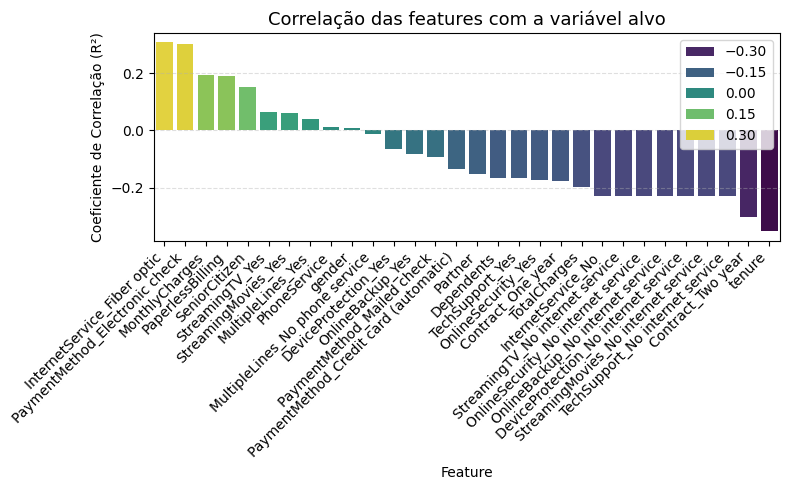

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

corr_target = corr_matrix['Churn'].drop('Churn').sort_values(ascending = False)

print(corr_target)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr_target.index, y=corr_target.values, palette='viridis', hue=corr_target.values)
plt.title('Correlação das features com a variável alvo', fontsize=13)
plt.ylabel('Coeficiente de Correlação (R²)')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Temos então a visualização das correlações de cada *feature* com a variável alvo. Destacando as 3 mais fortes:

|*Feature*|Correlação|*Insight*|
|:---:|:---:|:---:|
|**tenure**|$≈-0.35$ (**Negativa**)|Quanto maior o tempo de contrato, **menor** a chance de cancelamento. O *Churn* é um problema de clientes novos.|
|**InternetService_Fiber optic**|$≈0.31$ (**Positiva**)|Clientes que usam **Fibra Óptica** têm uma chance **maior** de cancelar. Isso pode indicar problemas de qualidade/confiabilidade nesse serviço ou preços altos.|
|**Contract_Two year**|$≈-0.30$ (**Negativa**)|Ter um contrato de longo prazo é o **maior fator de retenção**. Quanto maior o compromisso, menor o *churn*.|
|**PaymentMethod_Electronic check**|$≈0.30$ (**Positiva**)|Clientes que pagam via Cheque Eletrônico têm uma chance muito maior de cancelar. Pode indicar insatisfação imediata com a cobrança ou ser um método de pagamento associado a clientes de curto prazo.|
|**InternetService_No**|$≈-0.23$ (**Negativa**)|Clientes que não possuem serviço de internet têm uma chance **menor** de cancelar. Isso sugere que os serviços de internet da empresa são uma fonte da insatisfação.|

A análise das 5 primeiras *features* sugere que o problema de **Churn** está relacionado aos **serviços de internet** (`InternetService_Fiber optic` e `InternetService_No`), além no tempo de contrato.

---

## Modelagem Preditiva e Baseline
### Separação de Dados e Regressão Logística
Dividiremos o DataFrame primeiramente em *features* (`X`) e *target* (`y`), em seguida utilizaremos a função `train_test_split`, do *Scikit-learn*, para separar `X` e `y` em conjuntos de treino e teste. Com isso, será possível treinar o primeiro modelo de **Regressão Logística** (`LogisticRegression`), a partir do qual extrairemos as métricas que nos servirão como ***Baseline***.

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

AUC-ROC:
 0.8422


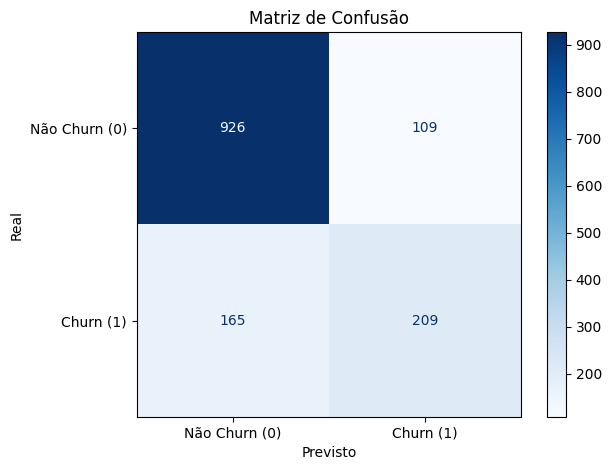

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

# Separação dos dados
X = df.drop(columns='Churn')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

# Instanciando e treinando o modelo
lr_model = LogisticRegression(max_iter=2500)
lr_model.fit(X_train, y_train)

# Previsões e Métricas
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:,1] # Previsão de probabilidades para o AUC

cm = confusion_matrix(y_test, y_pred)

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred)}")

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC:\n {auc_score:.4f}")

# Gráfico da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn (0)', 'Churn (1)'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.grid(False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

### Problema de Convergência (`ConvergenceWarning`)

Inicialmente, ao instanciar o modelo, não houve alterações nos hiperparâmetros. Contudo, ao rodar obtivemos um `ConvergenceWarning`. Para contornar esse problema, fez-se uma sequência de tentativas e erros até chegarmos a `max_iter=2500`.
O aviso de convergência ocorreu porque o algoritmo otimizador padrão (`lbfgs`) não conseguiu encontrar o conjunto ideal de coeficientes (pesos) que minimizam a função de perda (erro) dentro do limite máximo de iterações (`max_iter`). Se o conjunto de dados é grande, complexo, ou se as *features* estão em escalas muito diferentes, o otimizador precisa de muitos passos para se mover pelo espaço de parâmetros e chegar ao ponto ideal.
**Escala dos Dados:** Embora as *features* criadas pelo `pd.get_dummies()` sejam $0/1$, a coluna `TotalCharges` e `MonthlyCharges` (e especialmente a `tenure`) estão em uma escala diferente. A falta de **Escalonamento** (*Scaling*) das *features* numéricas (Padronização ou Normalização) faz com que o otimizador trabalhe mais, exigindo mais iterações para convergir.
Embora aumentar o `max_iter` para $2500$ tenha resolvido o warning, a prática comum para estabilizar a Regressão Logística é o **Escalonamento**.

### Avaliação do Modelo Baseline
<center>

|**Métrica**|**Resultado**|**Insight**|
|:-:|:-:|:-:|
|**Precisão**|Classe $0$: $0.85$</br>Classe $1$: $0.66$|Quando o modelo diz que um cliente vai cancelar (Classe $1$), ele está certo em $66$% das vezes.|
|**Recall**|Classe $0$: $0.89$</br>Classe $1$: $0.56$|Dos clientes que realmente **cancelaram**, o modelo só conseguiu identificar $56$% deles ($44$% são **Falsos Negativos**).|
|**Acurácia**|$0.81$|**Métrica Enganosa**. Parece boa ($81$%), mas é inflacionada pelo grande número de "Não Churn" (Classe $0$).|
|**AUC**|$0.8422$|**Métrica Chave**. O modelo tem uma boa capacidade de discriminação ($84.22$%), indicando que ele é </br>significativamente melhor que um palpite aleatório (AUC de $0.50$).|
</center>

Analisando a **Matriz de Confusão**, focando apenas no *Churn*, temos:
* **True Positives**: $56$% ($209$) - Clientes que cancelaram e foram corretamente previstos.
* **False Negative**: $44$% ($165$) - Clientes que cancelaram, mas o modelo errou, prevendo que **NÃO** cancelariam.

---

## Modelagem Avançada e Otimização
O objetivo agora é superar o *baseline*, focando na melhoria do **Recall**. O primeiro modelo a ser testado aqui é o **RandomForest**.

### Modelagem Avançada (Random Forest)
O **Random Forest Classifier** é um modelo de *ensemble* robusto, menos sensível à escala dos dados e capaz de capturar relações não-lineares. O foco é verificar se ele consegue aumentar significativamente o **Recall** da classe minoritária (`Churn`), superando o *baseline*.

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Instanciando o modelo
rf_model = RandomForestClassifier(
    n_estimators=300,
    criterion='gini',
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

# treinando o modelo
rf_model.fit(X_train, y_train)
print("Modelo Random Forest treinado com sucesso.")

Modelo Random Forest treinado com sucesso.


Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.79      1409

AUC-ROC:
 0.8267


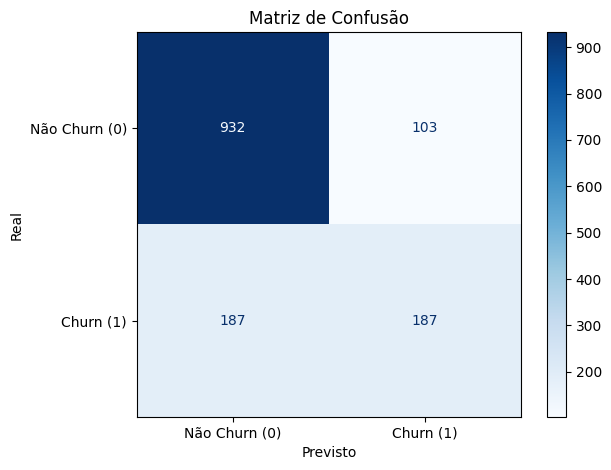

In [10]:
# Calculando as métricas
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred_rf)}")

auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC-ROC:\n {auc_score_rf:.4f}")

# Gráfico da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Não Churn (0)', 'Churn (1)'])
disp.plot(cmap='Blues', colorbar=True)
plt.title('Matriz de Confusão')
plt.grid(False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

### Avaliação do Modelo **Random Forest Classifier**

Aplicou-se o argumento `class_weight='balanced'` no `RandomForestClassifier`, uma técnica fundamental para lidar com desbalanceamento na variável alvo.
O **Random Forest** demonstrou ser significativamente melhor que o *baseline*, especialmente no tratamento dos **Falsos Negativos**.

<center>

|**Métrica**|***Baseline***|**Random Forest**|**Diferença**|
|:-:|:-:|:-:|:-:|
|**Precisão (Classe $1$)**|$0.66$|$0.64$|$-2$%|
|**Recall (Classe $1$)**|$0.56$|$0.50$|$-6$%|
|**Acurácia**|$0.81$|$0.79$|$-2$%|
|**AUC**|$0.8422$|$0.8267$|$-1.55$%|
</center>

**Análises:**
* **Queda no Recall**: Apesar de usarmos o `class_weight='balanced'`, o Recall **caiu de 0.56 para 0.50** (redução de 6%). Isso significa que, dos clientes que realmente cancelam, o RF identificou apenas metade.
* **Otimização é Essencial**: O Random Forest inicial se mostrou pior que o *baseline* em termos de Recall (nossa métrica de negócio), no entanto, podemos ainda otimizar esse modelo para verificarmos se é possível melhorar sua performance.

---


### Otimização do Random Forest (Grid Search)

A próxima etapa é otimizar o modelo  RandomForest através do Grid Search para encontrar a melhor combinação de hiperparâmetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definindo o espaço de busca
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2,3,5],
    'min_samples_leaf': [2,3,5],
    'max_features': ['sqrt', 'log2', None]    
}

# Configurando o GridSearch
grid_search = GridSearchCV(
    rf_model,
    param_grid=params,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nMelhores Parâmetros Encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Melhores Parâmetros Encontrados:
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


Definiu-se um espaço de busca abrangente e, crucialmente, utilizou-se o `scoring='recall'`, garantindo que o modelo otimizado mantenha o foco na minimização de Falsos Negativos.

**Melhores Parâmetros do Random Forest:**
<center>

|Parâmetro|Melhor Valor|Comentários|
|:-:|:-:|:-:|
|`max_depth`|$10$|Profundidade moderada, ajudando a evitar *overfitting* mantendo a capacidade preditiva.|
|`max_fatures`|`'log2'`|O modelo se beneficia ao considerar apenas `log2` ​(número de features) em cada divisão, introduzindo mais aleatoriedade e melhorando a generalização.|
|`min_samples_leaf`|$5$|Define que cada folha deve ter pelo menos 5 amostras, controlando o *overfitting* em folhas muito específicas.|
|`n_estimators`|$100$|Um número razoável de árvores que já foi suficiente para maximizar o Recall.|
</center>

---

### Avaliação do **Random Forest Otimizado**

In [13]:
# Definindo o melhor modelo pelo GridSearch

rf_model_optimized = grid_search.best_estimator_

y_pred_rf_optimized = rf_model_optimized.predict(X_test)
y_proba_rf_optimized = rf_model_optimized.predict_proba(X_test)[:,1]

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred_rf_optimized)}")

auc_score_rf_optimized = roc_auc_score(y_test, y_proba_rf_optimized)
print(f"AUC-ROC:\n {auc_score_rf_optimized:.4f}")

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.90      0.76      0.83      1035
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.78      1409

AUC-ROC:
 0.8437


Os resultados da avaliação do Random Forest Otimizado demonstram que a otimização focada no Recall foi bem-sucedida, alterando o *trade-off* do modelo de forma a beneficiar diretamente o negócio, que é a identificação de clientes em risco.

<center>

|**Métrica**|**Random Forest**|**Random Forest Otimizado**|**Diferença**|
|:-:|:-:|:-:|:-:|
|**Precisão (Classe $1$)**|$0.64$|$0.54$|$-10$%|
|**Recall (Classe $1$)**|$0.50$|$0.77$|$27$%|
|**Acurácia**|$0.79$|$0.76$|$-3$%|
|**AUC**|$0.8267$|$0.8437$|$1.7$%|
</center>

**Análises:**
* **Ganho Estratégico (Recall):** Aumento significativo de $27$%. Isso significa que, dos clientes que realmente cancelam, o modelo otimizado agora consegue identificar 77% deles. O número de Falsos Negativos (perda de clientes) foi significativamente reduzido, entregando grande valor de negócio.
* ***Trade-off* (Precisão):** Queda de $10$%. Isso significa que, de cada 10 previsões de "Vai Cancelar", 4 a 5 estarão erradas (Falsos Positivos). Custo de Negócio: O time de retenção terá que entrar em contato desnecessariamente com mais clientes. No entanto, para este problema, a prioridade é sempre o Recall, tornando o modelo Otimizado o melhor até o momento.
* **AUC (Melhora Geral):** Aumento de $1.7$%, superando inclusive o *baseline*, o que indica que o modelo tem uma capacidade de discriminação superior.

---

### Modelagem Avançada (XGBoost Classifier)

Além do Random Forest vamos testar o **XGBoost Classifier**, um algoritmo de *boosting* que frequentemente supera o Random Forest em performance.
Para combater o desbalanceamento, será utilizado o parâmetro `scale_pos_weight`, cujo valor é encontrado calculando a razão entre as classes: $N_0$​/$N_1$​ (Contagem de 'Não Churn' / Contagem de 'Churn').


In [15]:
print(df['Churn'].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


In [20]:
import xgboost as xgb

# Encontrando a razão entre N0 e N1

N_1 = df['Churn'].sum()
N_0 = len(df) - N_1
ratio = N_0/N_1

# Instanciando o modelo
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    scale_pos_weight=ratio,
    random_state=42,
    verbosity=0
)

# Treinamento do modelo
xgb_model.fit(X_train, y_train)

# Previsões e avaliação (exemplo)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred_xgb)}")

auc_score_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"AUC-ROC:\n {auc_score_xgb:.4f}")

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.76      1409

AUC-ROC:
 0.8449


### Análise do Modelo XGBoost (Não Otimizado)

O XGBoost Classifier demonstrou um desempenho altamente competitivo, especialmente no que tange ao Recall. Mesmo antes de ser otimizado, o modelo superou o Random Forest Otimizado em algumas métricas-chave.

<center>

|**Métrica**|**Random Forest Otimizado**|**XGBoost**|**Diferença**|
|:-:|:-:|:-:|:-:|
|**Precisão (Classe $1$)**|$0.54$|$0.51$|$-3$%|
|**Recall (Classe $1$)**|$0.77$|$0.81$|$4$%|
|**Acurácia**|$0.76$|$0.74$|$-2$%|
|**AUC**|$0.8437$|$0.8449$|$0.12$%|
</center>

**Análises:**
* **Recall superior:** O XGBoost, mesmo sem *tuning* fino, alcançou o Recall de $0.81$, superando o Random Forest Otimizado ($0.77$). Isso significa que ele identifica $81$% dos clientes em risco.
* **AUC Superior:** O AUC de $0.8449$ é o melhor entre todos os modelos testados (Reg. Logística: $0.8422$; RF Otimizado: $0.8437$)
* **Trade-off Aceitável:** A Precisão de $0.51$ é a mais baixa, indicando mais **Falsos Positivos**. Contudo, o grande ganho no Recall e o melhor AUC fazem do XGBoost o melhor modelo até o momento.

### Otimização do XGBoostClassifier (GridSearch)

O XGBoost, embora já seja o melhor em Recall ($0.81$) e AUC ($0.8449$), foi treinado com hiperparâmetros básicos. Portanto, iremos otimizá-lo.

In [23]:
# Definindo o espaço de busca
params_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03,0.05, 0.1, 0.15],
    'gamma': [0,0.1,0.5]
}

# Configurando o GridSearch
grid_search_xgb = GridSearchCV(
    xgb_model,
    param_grid=params_xgb,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

print("\nMelhores Parâmetros Encontrados:")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Melhores Parâmetros Encontrados:
{'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100}


A otimização, focada novamente no Recall, encontrou a seguinte combinação de parâmetros para o XGBoost.

**Melhores Parâmetros do XGBoost Classifier:**
<center>

|Parâmetro|Melhor Valor|Comentários|
|:-:|:-:|:-:|
|`max_depth`|$3$|Profundidade rasa, indicando que o modelo se beneficia da generalização.|
|`learning_rate`|$0.03$|Uma taxa de aprendizado baixa. O modelo prefere dar passos menores e mais cautelosos, melhorando a precisão do *boosting*.|
|`gamma`|$0.5$|Um valor moderado, que controla o limiar de perda necessário para fazer divisões. Isso ajuda a podar árvores e evita o *overfitting*.|
|`n_estimators`|$100$|O número padrão de árvores foi suficiente para alcançar o melhor Recall.|
</center>

---

### Avaliação do **XGBoost Otimizado**

In [24]:
# Definindo o melhor modelo pelo GridSearch

xgb_model_optimized = grid_search_xgb.best_estimator_

y_pred_xgb_optimized = xgb_model_optimized.predict(X_test)
y_proba_xgb_optimized = xgb_model_optimized.predict_proba(X_test)[:,1]

print(f"Relatório de Classificação: \n {classification_report(y_test, y_pred_xgb_optimized)}")

auc_score_xgb_optimized = roc_auc_score(y_test, y_proba_xgb_optimized)
print(f"AUC-ROC:\n {auc_score_xgb_optimized:.4f}")

Relatório de Classificação: 
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.75      1409

AUC-ROC:
 0.8431


O resultado da otimização com foco no Recall (`scoring='recall'`) consolidou o XGBoost como o modelo de melhor desempenho para a necessidade de negócio.

<center>

|**Métrica**|**XGBoost**|**XGBoost Otimizado**|**Diferença**|
|:-:|:-:|:-:|:-:|
|**Precisão (Classe $1$)**|$0.51$|$0.50$|$-1$%|
|**Recall (Classe $1$)**|$0.81$|$0.82$|$1$%|
|**Acurácia**|$0.74$|$0.74$|$0$|
|**AUC**|$0.8449$|$0.8431$|$-0.18$%|
</center>

**Análises:**
* **Recall Máximo:** O modelo obteve o maior Recall de todos os testes ($0.82$), o que significa que ele identifica corretamente $≈82$% dos clientes que realmente cancelarão. Isso minimiza o custo de Falsos Negativos (perda de clientes) e é o resultado mais valioso para o time de retenção.
* ***Trade-off* Aceitável:** A baixa Precisão ($0.50$) significa que, de cada $10$ alertas de Churn, $5$ serão Falsos Positivos. Embora isso gere um custo operacional (contato desnecessário), é um *trade-off* aceitável quando o custo de perder um cliente real é muito maior.
* **AUC Robusto:** O poder de discriminação do modelo é excelente, superando nosso *baseline*.

---